In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [8]:
env.step(env.action_space.sample())

((16, 1, False), -1, True, {})

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [5]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        action_probs = Q[observation]
        best_action = np.argmax(action_probs)
        return np.eye(len(action_probs))[best_action]
        
    return policy_fn

In [53]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        state = env.reset()
        G = 0
        W = 1
        episode = []
        for t in range(100):
            action_probs = behavior_policy(state)
            action = np.random.choice(np.arange(env.nA), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
        for state, action, reward in reversed(episode):
            state = tuple(state)
            G = discount_factor*G + reward
            C[state][action] = C[state][action] + W
            Q[state][action] = Q[state][action] + W/C[state][action]*(G-Q[state][action])
            if action != np.argmax(Q[state]):
                break
            W = W / behavior_policy(state)[action]      
        
    return Q, target_policy

In [54]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

In [56]:
Q

defaultdict(<function __main__.mc_control_importance_sampling.<locals>.<lambda>()>,
            {(14, 4, False): array([-0.2427907 , -0.31764706]),
             (12, 4, False): array([-0.24732143, -0.24246639]),
             (19, 10, False): array([-0.01458771, -0.75944334]),
             (18, 9, False): array([-0.19628906, -0.58885687]),
             (13, 9, True): array([-0.47272727,  0.02608696]),
             (17, 10, False): array([-0.46601827, -0.62253037]),
             (19, 4, False): array([ 0.41146626, -0.74635128]),
             (18, 10, False): array([-0.230722, -0.676638]),
             (14, 1, False): array([-0.74778967, -0.60620757]),
             (20, 4, False): array([ 0.66341463, -0.8814202 ]),
             (17, 4, False): array([-0.10776699, -0.513356  ]),
             (18, 6, False): array([ 0.29211295, -0.61575875]),
             (21, 4, False): array([ 0.89047619, -1.        ]),
             (21, 4, True): array([0.88868778, 0.35393258]),
             (12, 10, Fal

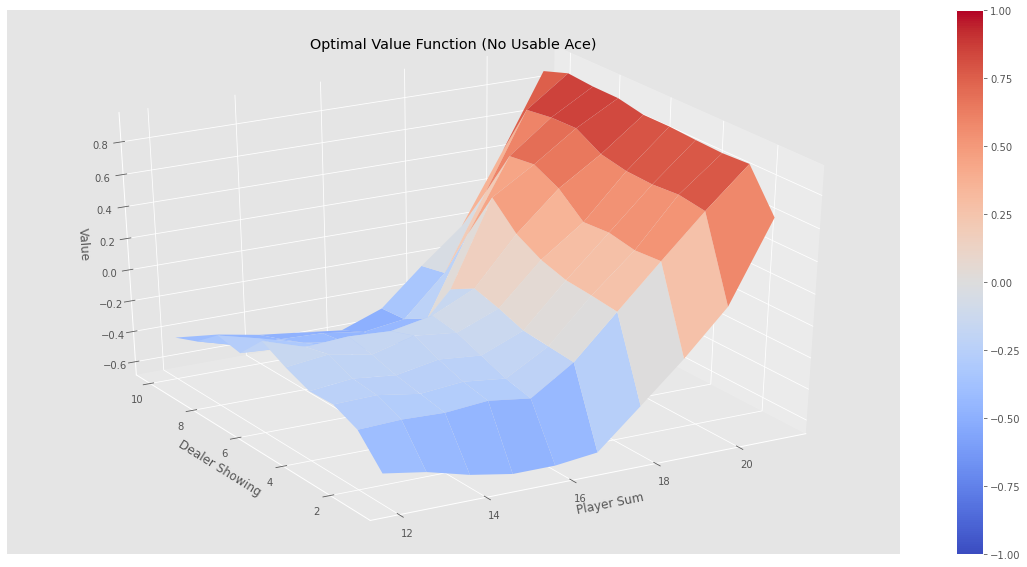

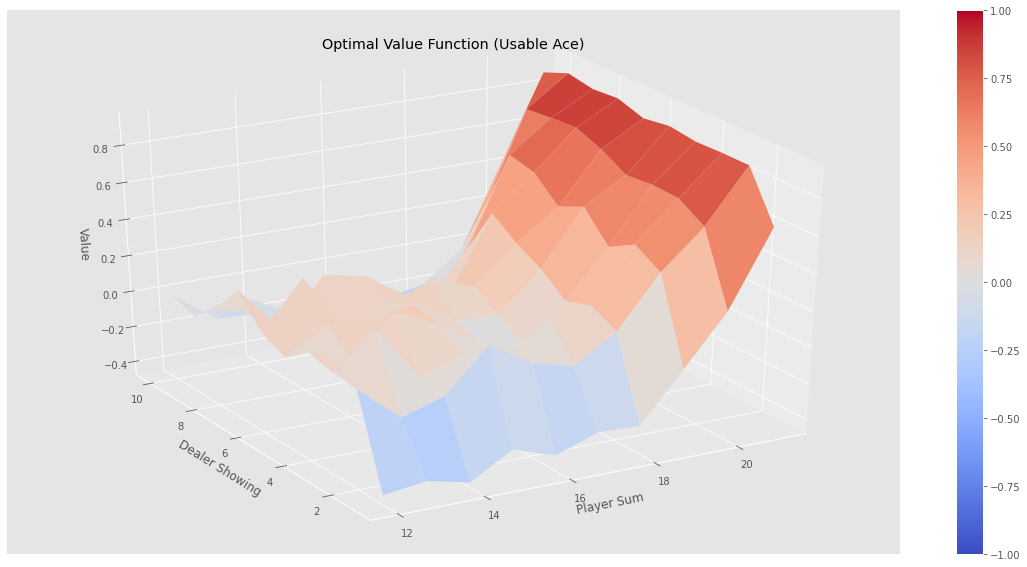

In [55]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")